## Import libraries and load dataset from data cleaning.ipynb

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [2]:
url = "https://github.com/mdimran1/Dataset/blob/main/real_estate/cleaned_apartment.csv?raw=true"

clean_data = pd.read_csv(url,index_col=0)

# check data types
clean_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41123 entries, 0 to 41122
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   postal_code             41123 non-null  int64 
 1   type_of_property        41123 non-null  int64 
 2   price                   41123 non-null  int64 
 3   number_of_rooms         41123 non-null  int64 
 4   house_area              41123 non-null  int64 
 5   fully_equipped_kitchen  41123 non-null  int64 
 6   open_fire               41123 non-null  int64 
 7   terrace                 41123 non-null  int64 
 8   garden                  41123 non-null  int64 
 9   surface_of_the_land     41123 non-null  int64 
 10  number_of_facades       41123 non-null  int64 
 11  swimming_pool           41123 non-null  int64 
 12  state_of_the_building   41123 non-null  object
dtypes: int64(12), object(1)
memory usage: 4.4+ MB


In [3]:
clean_data['state_of_the_building']

0        to be done up
1               as new
2                 good
3                 good
4               as new
             ...      
41118          unknown
41119          unknown
41120          unknown
41121          unknown
41122          unknown
Name: state_of_the_building, Length: 41123, dtype: object

## Feature correlation

In [4]:
# Independent variable :

x = clean_data.drop(columns=['price', 'state_of_the_building'])

# dependent / target variables :
y = clean_data['price']

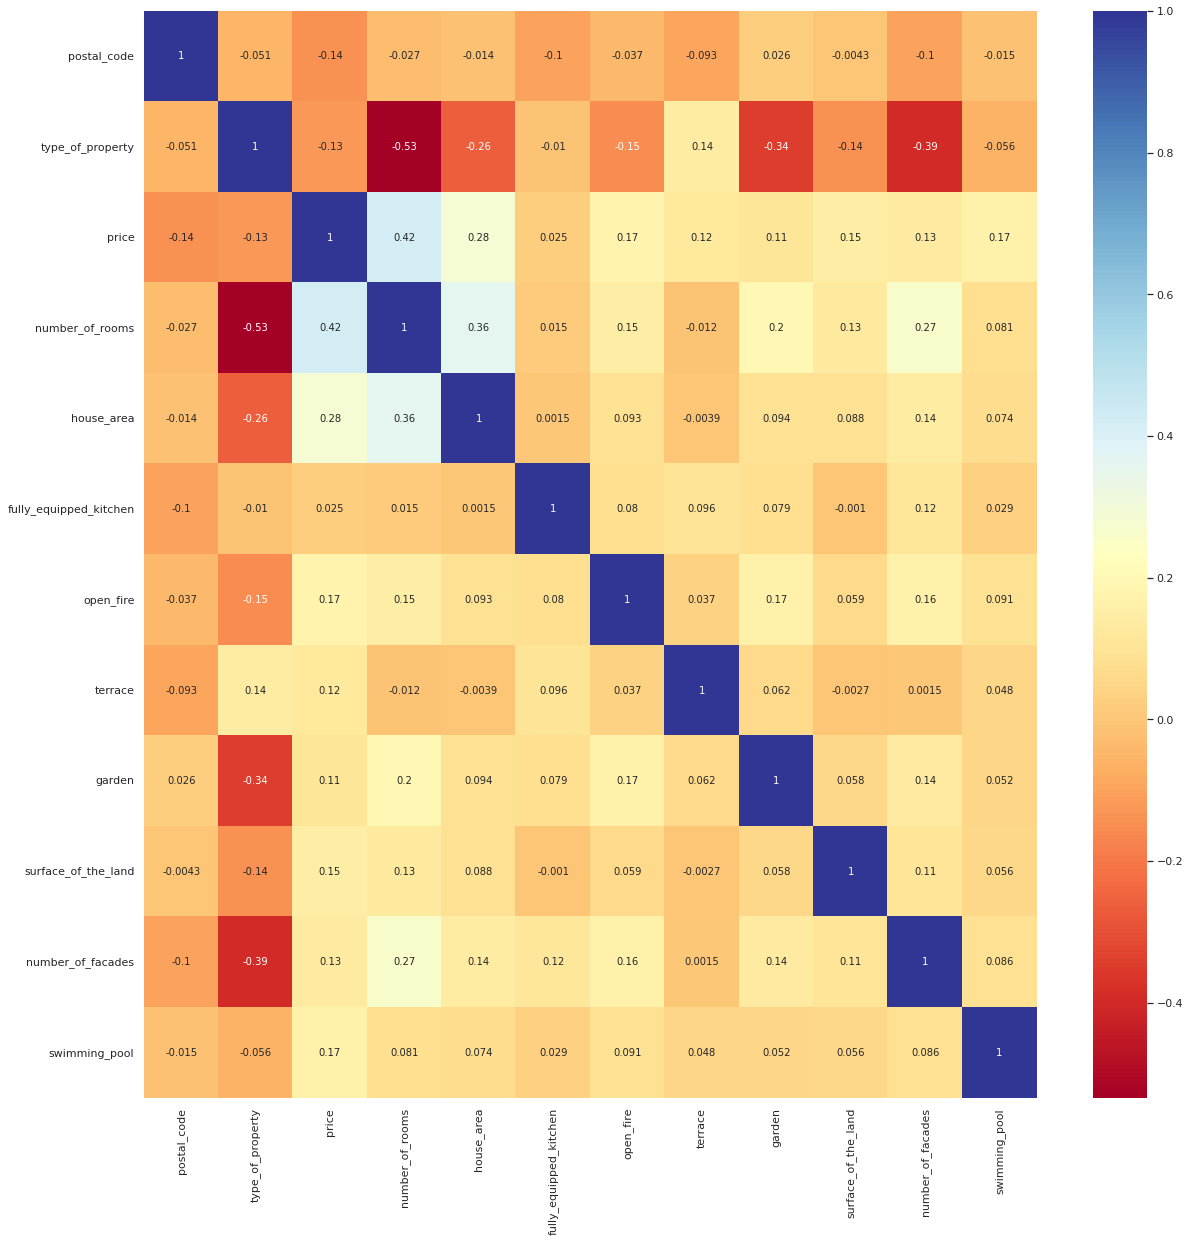

In [5]:
# plotting heatmap by Correlation

relation = clean_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(relation, annot=True, cmap='RdYlBu')
plt.show()

In [6]:
# Most correalated features finding

from sklearn.ensemble import ExtraTreesRegressor # import necessery class

most_corr = ExtraTreesRegressor().fit(x,y) #  fitting data

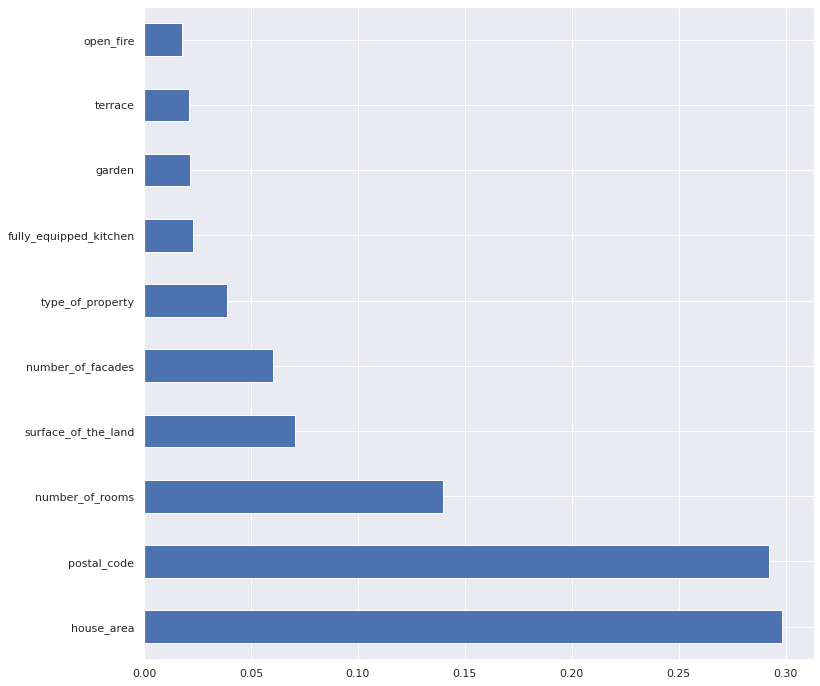

In [7]:
# Ploting top 10 most contributed feature :

feat_imp = pd.Series(most_corr.feature_importances_, index=x.columns)  # transform to pandas series for better understanding
#feat_imp.nlargest(10).plot(kind='barh')

plt.figure(figsize=(12,12))
feat_imp.sort_values(ascending=False)[:10].plot(kind='barh')
plt.show()

## Data separation for Training & Testing

In [8]:
# importing necessary class :
from sklearn.model_selection import train_test_split  

# Spliting for model testing
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=12)

## Model Development & Metrics:

In [9]:
# import r^2 score class:
# model metrics:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score


In [10]:
# Random Forest model & perdict:

from sklearn.ensemble import RandomForestRegressor
ran_forest = RandomForestRegressor()
ran_forest.fit(x_train, y_train) # fitting model
y_ran_forest = ran_forest.predict(x_test) #prediction price


# Metrics :
print(f'R_Squared errors : {r2_score(y_test, y_ran_forest)}')
print(f'Mean Squared Errors : {mse(y_test, y_ran_forest)}')

R_Squared errors : 0.7152659691442838
Mean Squared Errors : 8269582227.867272


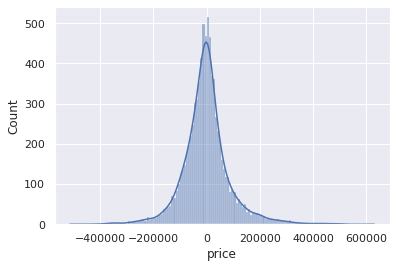

In [11]:
# Ploting model performance distribution :
sns.histplot(y_test- y_ran_forest, kde=True)
plt.show()

## Hypertune :

In [12]:
# Tuning by Microsoft LightGBM with FLAML Library

!pip install flaml[notebook];
from flaml import AutoML
automl = AutoML()

In [13]:
# perameters 

settings = {
    "time_budget": 180,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression 
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [14]:
automl.fit(X_train=x_train, y_train=y_train, **settings)

[flaml.automl: 03-07 17:51:40] {2068} INFO - task = regression
[flaml.automl: 03-07 17:51:40] {2070} INFO - Data split method: uniform
[flaml.automl: 03-07 17:51:40] {2074} INFO - Evaluation method: cv
[flaml.automl: 03-07 17:51:40] {2155} INFO - Minimizing error metric: 1-r2
[flaml.automl: 03-07 17:51:40] {2248} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 03-07 17:51:40] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-07 17:51:40] {2617} INFO - Estimated sufficient time budget=2904s. Estimated necessary time budget=3s.
[flaml.automl: 03-07 17:51:40] {2669} INFO -  at 0.4s,	estimator lgbm's best error=0.8123,	best estimator lgbm's best error=0.8123
[flaml.automl: 03-07 17:51:40] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-07 17:51:40] {2669} INFO -  at 0.7s,	estimator lgbm's best error=0.8123,	best estimator lgbm's best error=0.8123
[flaml.automl: 03-07 17:51:40] {2501} INFO - iteration 2, current learner lgbm
[flaml.automl:

In [15]:
## Best model and metric

tune = automl.best_config
automl.model.estimator

LGBMRegressor(colsample_bytree=0.9185803230557161,
              learning_rate=0.16691052901143322, max_bin=1023,
              min_child_samples=13, n_estimators=470, num_leaves=44,
              reg_alpha=0.0010949400705571237, reg_lambda=0.0023043354407430027,
              verbose=-1)

In [16]:
# prediction
y_Automl = automl.predict(x_test)

# Metrics :
print(f'R_Squared errors : {r2_score(y_test, y_Automl)}')
print(f'Mean Squared Errors : {mse(y_test, y_Automl)}')

R_Squared errors : 0.7371819945041573
Mean Squared Errors : 7633071118.61621


## Model Selection 

---
LGBMRegressor is the most accurate.
 

In [17]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(**tune)

In [18]:
# fit
lgbm.fit(x_train, y_train)

# predict
y_lgbm = lgbm.predict(x_test)

# Metrics :
print(f'R_Squared errors : {r2_score(y_test, y_Automl)}')
print(f'Mean Squared Errors : {mse(y_test, y_Automl)}')

[LightGBM] [Warning] Unknown parameter: log_max_bin
R_Squared errors : 0.7371819945041573
Mean Squared Errors : 7633071118.61621


## Model (pickle) Dumping 


In [19]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(lgbm, f, pickle.HIGHEST_PROTOCOL)